## HW1


In [25]:
import sys
print(sys.executable)
%pip install -q yfinance pandas numpy matplotlib scikit-learn torch


c:\Users\PJdesk\AppData\Local\Programs\Python\Python313\python.exe
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

def get_price(tick,start='2022-10-01',end=None):
    return yf.Ticker(tick).history(start=start,end=end)['Close']

def get_prices(tickers,start='2022-10-01',end=None):
    df=pd.DataFrame()
    for s in tickers:
        df[s]=get_price(s,start,end)
    return df

## Prepare training and testing data sets

In [27]:
feature_stocks = ["tsla","meta","goog","amzn","nflx","gbtc","gdx","intc","dal","c"]
predict_stock = "msft"

start_all = "2023-01-01"
end_all   = "2024-12-31"

X_all = get_prices(feature_stocks, start=start_all, end=end_all)
y_all = get_prices([predict_stock], start=start_all, end=end_all)

data = pd.concat([X_all, y_all], axis=1).dropna()
data.head()

train_start, train_end = "2023-01-01", "2024-06-30"
val_start,   val_end   = "2024-07-01", "2024-10-31"
test_start,  test_end  = "2024-11-01", "2024-12-31"

train_df = data.loc[train_start:train_end].copy()
val_df   = data.loc[val_start:val_end].copy()
test_df  = data.loc[test_start:test_end].copy()

print("Train:", train_df.shape, train_df.index.min().date(), "to", train_df.index.max().date())
print("Val:  ", val_df.shape,   val_df.index.min().date(),   "to", val_df.index.max().date())
print("Test: ", test_df.shape,  test_df.index.min().date(),  "to", test_df.index.max().date())

X_train_df = train_df[feature_stocks]
y_train_df = train_df[[predict_stock]]

X_val_df = val_df[feature_stocks]
y_val_df = val_df[[predict_stock]]

X_test_df = test_df[feature_stocks]
y_test_df = test_df[[predict_stock]]

Train: (374, 11) 2023-01-03 to 2024-06-28
Val:   (87, 11) 2024-07-01 to 2024-10-31
Test:  (40, 11) 2024-11-01 to 2024-12-30


## Linear Regression

In [28]:
X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()

X_val = X_val_df.to_numpy()
y_val = y_val_df.to_numpy()

X_test = X_test_df.to_numpy()
y_test = y_test_df.to_numpy()

X_train_b = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
X_val_b   = np.hstack([np.ones((X_val.shape[0], 1)),   X_val])
X_test_b  = np.hstack([np.ones((X_test.shape[0], 1)),  X_test])

w = np.linalg.pinv(X_train_b.T @ X_train_b) @ (X_train_b.T @ y_train)

yhat_train = X_train_b @ w
yhat_val   = X_val_b   @ w
yhat_test  = X_test_b  @ w

mse_train_lr = float(np.mean((y_train - yhat_train)**2))
mse_val_lr   = float(np.mean((y_val   - yhat_val  )**2))
mse_test_lr  = float(np.mean((y_test  - yhat_test )**2))

print("Linear Regression MSE")
print("Train:", mse_train_lr)
print("Val:  ", mse_val_lr)
print("Test: ", mse_test_lr)

Linear Regression MSE
Train: 78.69593116450596
Val:   2185.1214912342325
Test:  7167.110273809454


## Prepare data for neural network

In [29]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_s = scaler_X.fit_transform(X_train)
X_val_s   = scaler_X.transform(X_val)
X_test_s  = scaler_X.transform(X_test)

y_train_s = scaler_y.fit_transform(y_train).reshape(-1, 1)
y_val_s   = scaler_y.transform(y_val).reshape(-1, 1)
y_test_s  = scaler_y.transform(y_test).reshape(-1, 1)

X_train_s.shape, y_train_s.shape

((374, 10), (374, 1))

## 5 hidden layers × 20 neurons

In [30]:
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 64
train_loader = DataLoader(StockDataset(X_train_s, y_train_s), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(StockDataset(X_val_s,   y_val_s),   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(StockDataset(X_test_s,  y_test_s),  batch_size=batch_size, shuffle=False)

class FCN_5x20(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        dims = [in_dim] + [20]*5 + [1]
        layers = []
        for i in range(len(dims)-2):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(dims[-2], dims[-1]))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

def mse_scaled(model, loader):
    model.eval()
    loss_fn = nn.MSELoss(reduction="sum")
    total, n = 0.0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            total += loss_fn(pred, yb).item()
            n += len(xb)
    return total / n

def mse_real_price(model, loader):
    model.eval()
    preds, ys = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            pred = model(xb).cpu().numpy()
            y = yb.numpy()
            preds.append(pred); ys.append(y)
    pred_s = np.vstack(preds)
    y_s = np.vstack(ys)
    pred_real = scaler_y.inverse_transform(pred_s)
    y_real = scaler_y.inverse_transform(y_s)
    return float(np.mean((pred_real - y_real)**2))

def train_loop(model, optimizer, epochs, scheduler=None, scheduler_type=None):
    loss_fn = nn.MSELoss()
    hist = {"train_loss": [], "val_loss": []}
    for epoch in range(1, epochs+1):
        model.train()
        total, n = 0.0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()
            if scheduler is not None and scheduler_type in ["onecycle", "cyclic"]:
                scheduler.step()
            total += loss.item() * len(xb)
            n += len(xb)
        train_loss = total / n
        val_loss = mse_scaled(model, val_loader)
        if scheduler is not None and scheduler_type == "plateau":
            scheduler.step(val_loss)
        hist["train_loss"].append(train_loss)
        hist["val_loss"].append(val_loss)
        if epoch in [1, 5, 10] or epoch % 20 == 0:
            lr_now = optimizer.param_groups[0]["lr"]
            print(f"Epoch {epoch:3d}/{epochs} | train {train_loss:.6f} | val {val_loss:.6f} | lr {lr_now:.3e}")
    return hist


## TRY SGD, MOMENTUM, AND ADAM

=== SGD ===
Epoch   1/200 | train 1.000591 | val 1.842683 | lr 1.000e-02
Epoch   5/200 | train 0.998656 | val 1.870030 | lr 1.000e-02
Epoch  10/200 | train 0.996354 | val 1.884146 | lr 1.000e-02
Epoch  20/200 | train 0.991271 | val 1.871045 | lr 1.000e-02
Epoch  40/200 | train 0.964291 | val 1.765274 | lr 1.000e-02
Epoch  60/200 | train 0.809768 | val 1.284117 | lr 1.000e-02
Epoch  80/200 | train 0.205972 | val 0.102504 | lr 1.000e-02
Epoch 100/200 | train 0.084623 | val 0.079002 | lr 1.000e-02
Epoch 120/200 | train 0.055314 | val 0.068766 | lr 1.000e-02
Epoch 140/200 | train 0.040038 | val 0.069268 | lr 1.000e-02
Epoch 160/200 | train 0.030962 | val 0.071226 | lr 1.000e-02
Epoch 180/200 | train 0.025540 | val 0.074897 | lr 1.000e-02
Epoch 200/200 | train 0.022203 | val 0.075111 | lr 1.000e-02

=== Momentum ===
Epoch   1/200 | train 1.024087 | val 2.196616 | lr 1.000e-02
Epoch   5/200 | train 0.996042 | val 1.880969 | lr 1.000e-02
Epoch  10/200 | train 0.955954 | val 1.950386 | lr 1.00

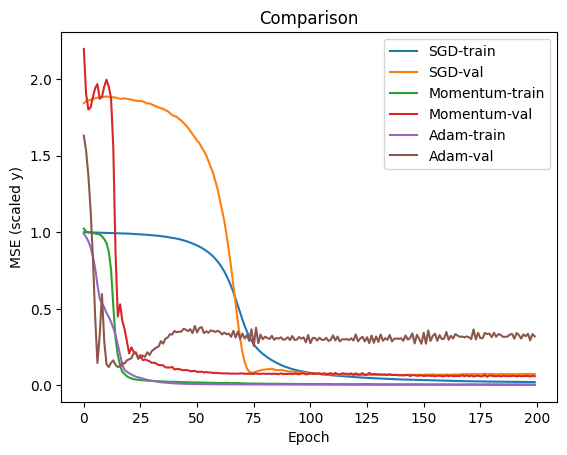

In [31]:
torch.manual_seed(0)
np.random.seed(0)

epochs = 200
in_dim = X_train_s.shape[1]

results_opt = {}

model_sgd = FCN_5x20(in_dim).to(device)
opt_sgd = torch.optim.SGD(model_sgd.parameters(), lr=1e-2)
print("=== SGD ===")
hist_sgd = train_loop(model_sgd, opt_sgd, epochs)
results_opt["SGD"] = (hist_sgd, model_sgd)

model_mom = FCN_5x20(in_dim).to(device)
opt_mom = torch.optim.SGD(model_mom.parameters(), lr=1e-2, momentum=0.9)
print("\n=== Momentum ===")
hist_mom = train_loop(model_mom, opt_mom, epochs)
results_opt["Momentum"] = (hist_mom, model_mom)

model_adam = FCN_5x20(in_dim).to(device)
opt_adam = torch.optim.Adam(model_adam.parameters(), lr=1e-3)
print("\n=== Adam ===")
hist_adam = train_loop(model_adam, opt_adam, epochs)
results_opt["Adam"] = (hist_adam, model_adam)

plt.figure()
for name, (hist, _) in results_opt.items():
    plt.plot(hist["train_loss"], label=f"{name}-train")
    plt.plot(hist["val_loss"],   label=f"{name}-val")
plt.xlabel("Epoch")
plt.ylabel("MSE (scaled y)")
plt.title("Comparison")
plt.legend()
plt.show()


In [32]:
for name, (hist, m) in results_opt.items():
    train_mse = mse_real_price(m, train_loader)
    val_mse   = mse_real_price(m, val_loader)
    test_mse  = mse_real_price(m, test_loader)
    print(f"{name:8s} | Train MSE: {train_mse:.4f} | Val MSE: {val_mse:.4f} | Test MSE: {test_mse:.4f}")


SGD      | Train MSE: 75.3721 | Val MSE: 257.6661 | Test MSE: 2101.6814
Momentum | Train MSE: 19.5372 | Val MSE: 207.6346 | Test MSE: 670.4241
Adam     | Train MSE: 12.3351 | Val MSE: 1099.8107 | Test MSE: 5331.7959


## learning rate schedulers

=== OneCycleLR (Momentum) ===
Epoch   1/200 | train 1.000437 | val 1.837368 | lr 1.220e-03
Epoch   5/200 | train 0.997841 | val 1.893894 | lr 1.693e-03
Epoch  10/200 | train 0.989734 | val 1.874956 | lr 3.140e-03
Epoch  20/200 | train 0.356867 | val 0.314554 | lr 8.436e-03
Epoch  40/200 | train 0.012277 | val 0.094186 | lr 2.287e-02
Epoch  60/200 | train 0.008816 | val 0.106452 | lr 3.000e-02
Epoch  80/200 | train 0.007403 | val 0.095130 | lr 2.849e-02
Epoch 100/200 | train 0.006913 | val 0.107453 | lr 2.431e-02
Epoch 120/200 | train 0.006033 | val 0.095601 | lr 1.828e-02
Epoch 140/200 | train 0.005089 | val 0.097027 | lr 1.161e-02
Epoch 160/200 | train 0.005014 | val 0.089980 | lr 5.604e-03
Epoch 180/200 | train 0.004760 | val 0.089739 | lr 1.461e-03
Epoch 200/200 | train 0.004691 | val 0.087890 | lr 2.249e-07

=== CyclicLR (Momentum) ===
Epoch   1/200 | train 1.028182 | val 2.307524 | lr 6.800e-03
Epoch   5/200 | train 0.995707 | val 1.937310 | lr 3.000e-02
Epoch  10/200 | train 0.91

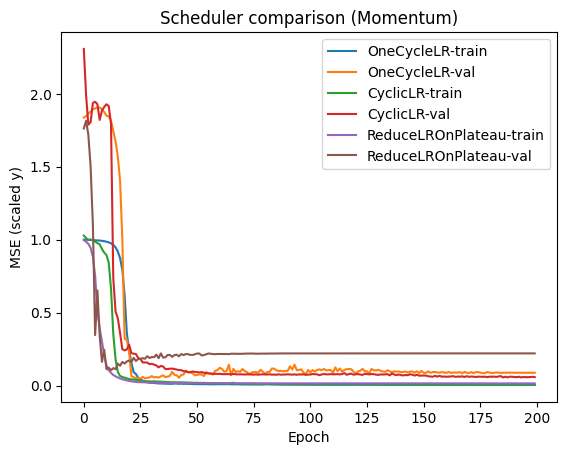

In [33]:
epochs = 200
steps_per_epoch = len(train_loader)
in_dim = X_train_s.shape[1]

results_sched = {}

torch.manual_seed(0)
np.random.seed(0)

# OneCycleLR + Momentum
model_oc = FCN_5x20(in_dim).to(device)
opt_oc = torch.optim.SGD(model_oc.parameters(), lr=1e-2, momentum=0.9)
sched_oc = torch.optim.lr_scheduler.OneCycleLR(
    opt_oc, max_lr=3e-2, epochs=epochs, steps_per_epoch=steps_per_epoch
)
print("=== OneCycleLR (Momentum) ===")
hist_oc = train_loop(model_oc, opt_oc, epochs, scheduler=sched_oc, scheduler_type="onecycle")
results_sched["OneCycleLR"] = (hist_oc, model_oc)

# CyclicLR + Momentum
model_cyc = FCN_5x20(in_dim).to(device)
opt_cyc = torch.optim.SGD(model_cyc.parameters(), lr=1e-3, momentum=0.9)
sched_cyc = torch.optim.lr_scheduler.CyclicLR(
    opt_cyc, base_lr=1e-3, max_lr=3e-2, step_size_up=steps_per_epoch*5
)
print("\n=== CyclicLR (Momentum) ===")
hist_cyc = train_loop(model_cyc, opt_cyc, epochs, scheduler=sched_cyc, scheduler_type="cyclic")
results_sched["CyclicLR"] = (hist_cyc, model_cyc)

# ReduceLROnPlateau + Momentum
model_pl = FCN_5x20(in_dim).to(device)
opt_pl = torch.optim.SGD(model_pl.parameters(), lr=1e-2, momentum=0.9)
sched_pl = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt_pl, mode="min", factor=0.5, patience=10
)
print("\n=== ReduceLROnPlateau (Momentum) ===")
hist_pl = train_loop(model_pl, opt_pl, epochs, scheduler=sched_pl, scheduler_type="plateau")
results_sched["ReduceLROnPlateau"] = (hist_pl, model_pl)

plt.figure()
for name, (hist, _) in results_sched.items():
    plt.plot(hist["train_loss"], label=f"{name}-train")
    plt.plot(hist["val_loss"],   label=f"{name}-val")
plt.xlabel("Epoch")
plt.ylabel("MSE (scaled y)")
plt.title("Scheduler comparison (Momentum)")
plt.legend()
plt.show()

In [34]:
for name, (hist, m) in results_sched.items():
    train_mse = mse_real_price(m, train_loader)
    val_mse   = mse_real_price(m, val_loader)
    test_mse  = mse_real_price(m, test_loader)
    print(f"{name:18s} | Train MSE: {train_mse:.4f} | Val MSE: {val_mse:.4f} | Test MSE: {test_mse:.4f}")


OneCycleLR         | Train MSE: 16.0906 | Val MSE: 301.5023 | Test MSE: 1943.3519
CyclicLR           | Train MSE: 19.8889 | Val MSE: 198.4424 | Test MSE: 705.3007
ReduceLROnPlateau  | Train MSE: 52.2876 | Val MSE: 757.3118 | Test MSE: 6149.9033


In [35]:
best_name = min(
    results_sched.keys(),
    key=lambda k: mse_real_price(results_sched[k][1], val_loader)
)

best_model = results_sched[best_name][1]

print("Best model by validation:", best_name)

def save_weights(model, path):
    payload = {
        "model_state_dict": model.state_dict(),
        "feature_stocks": feature_stocks,
        "target_stock": predict_stock,
        "scaler_X_mean": scaler_X.mean_,
        "scaler_X_scale": scaler_X.scale_,
        "scaler_y_mean": scaler_y.mean_,
        "scaler_y_scale": scaler_y.scale_,
    }
    torch.save(payload, path)
    return path

save_path = save_weights(best_model, "msft_fcn_weights.pth")
save_path

Best model by validation: CyclicLR


'msft_fcn_weights.pth'

## Model Design Challenge 

### Count the parameter

In [36]:
def count_params(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

baseline = FCN_5x20(in_dim=X_train_s.shape[1]).to(device)
baseline_params = count_params(baseline)
baseline_params

1921

### (hidden=16）+ Dropout


In [37]:
class FCN_Slim(nn.Module):
    def __init__(self, in_dim, hidden=16, dropout=0.1):
        super().__init__()
        dims = [in_dim] + [hidden]*5 + [1]
        layers = []
        for i in range(len(dims)-2):
            layers += [nn.Linear(dims[i], dims[i+1]), nn.ReLU(), nn.Dropout(dropout)]
        layers += [nn.Linear(dims[-2], dims[-1])]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

cand_a = FCN_Slim(X_train_s.shape[1], hidden=16, dropout=0.1).to(device)
count_params(cand_a), baseline_params

(1281, 1921)

In [38]:
class FCN_Residual(nn.Module):
    def __init__(self, in_dim, hidden=16):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, hidden)
        self.fc4 = nn.Linear(hidden, hidden)
        self.fc5 = nn.Linear(hidden, hidden)
        self.out = nn.Linear(hidden, 1)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.fc1(x))
        residual = x
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))
        x = x + residual
        x = self.act(self.fc4(x))
        x = self.act(self.fc5(x))
        return self.out(x)

### best-val checkpoint

In [39]:
def train_loop_bestval(model, optimizer, epochs, scheduler=None, scheduler_type=None):
    loss_fn = nn.MSELoss()
    hist = {"train_loss": [], "val_loss": []}

    best_val = float("inf")
    best_state = None

    for epoch in range(1, epochs+1):
        model.train()
        total, n = 0.0, 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()

            if scheduler is not None and scheduler_type in ["onecycle", "cyclic"]:
                scheduler.step()

            total += loss.item() * len(xb)
            n += len(xb)

        train_loss = total / n
        val_loss = mse_scaled(model, val_loader)

        if scheduler is not None and scheduler_type == "plateau":
            scheduler.step(val_loss)

        hist["train_loss"].append(train_loss)
        hist["val_loss"].append(val_loss)

        if val_loss < best_val:
            best_val = val_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        if epoch in [1, 5, 10] or epoch % 20 == 0:
            lr_now = optimizer.param_groups[0]["lr"]
            print(f"Epoch {epoch:3d}/{epochs} | train {train_loss:.6f} | val {val_loss:.6f} | lr {lr_now:.3e}")

    model.load_state_dict(best_state)
    return hist, best_val

### Train the candidate

Candidate A params: 1281  (baseline: 1921 )
=== Train Candidate A (Slim+Dropout, Momentum+CyclicLR) ===
Epoch   1/200 | train 1.007197 | val 2.099520 | lr 6.800e-03
Epoch   5/200 | train 0.924314 | val 1.732889 | lr 3.000e-02
Epoch  10/200 | train 0.205378 | val 0.081100 | lr 1.000e-03
Epoch  20/200 | train 0.202240 | val 0.108663 | lr 1.000e-03
Epoch  40/200 | train 0.125128 | val 0.111145 | lr 1.000e-03
Epoch  60/200 | train 0.099781 | val 0.091558 | lr 1.000e-03
Epoch  80/200 | train 0.074534 | val 0.096399 | lr 1.000e-03
Epoch 100/200 | train 0.090507 | val 0.097221 | lr 1.000e-03
Epoch 120/200 | train 0.079386 | val 0.094634 | lr 1.000e-03
Epoch 140/200 | train 0.090161 | val 0.090300 | lr 1.000e-03
Epoch 160/200 | train 0.060308 | val 0.089746 | lr 1.000e-03
Epoch 180/200 | train 0.069075 | val 0.085610 | lr 1.000e-03
Epoch 200/200 | train 0.064929 | val 0.086224 | lr 1.000e-03


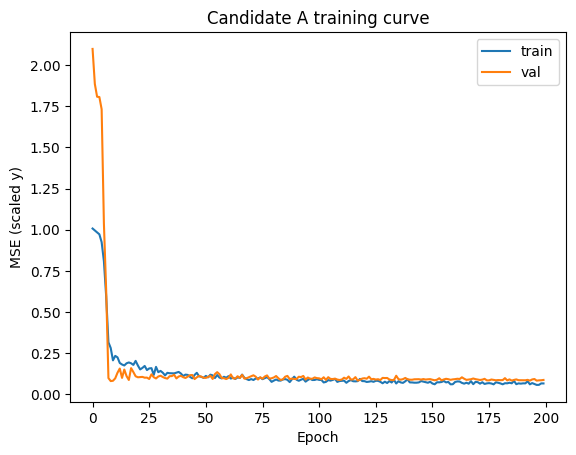

Best Val (scaled y): 0.07931664483300571
Val MSE (real $): 272.0928039550781


In [40]:
torch.manual_seed(0)
np.random.seed(0)

epochs = 200
steps_per_epoch = len(train_loader)

candidate_models = {}

m = FCN_Slim(X_train_s.shape[1], hidden=16, dropout=0.1).to(device)
print("Candidate A params:", count_params(m), " (baseline:", baseline_params, ")")

opt = torch.optim.SGD(m.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)
sched = torch.optim.lr_scheduler.CyclicLR(
    opt, base_lr=1e-3, max_lr=3e-2, step_size_up=steps_per_epoch*5
)

print("=== Train Candidate A (Slim+Dropout, Momentum+CyclicLR) ===")
hist, best_val = train_loop_bestval(m, opt, epochs, scheduler=sched, scheduler_type="cyclic")

candidate_models["CandA_Slim16_Dropout0.1"] = (m, hist, best_val)

plt.figure()
plt.plot(hist["train_loss"], label="train")
plt.plot(hist["val_loss"], label="val")
plt.xlabel("Epoch")
plt.ylabel("MSE (scaled y)")
plt.title("Candidate A training curve")
plt.legend()
plt.show()

print("Best Val (scaled y):", best_val)
print("Val MSE (real $):", mse_real_price(m, val_loader))

### Compare with the baseline

Baseline params: 1921
=== Train Baseline (Momentum+CyclicLR) ===
Epoch   1/200 | train 1.000461 | val 1.845843 | lr 6.800e-03
Epoch   5/200 | train 0.982014 | val 1.795666 | lr 3.000e-02
Epoch  10/200 | train 0.556066 | val 0.406064 | lr 1.000e-03
Epoch  20/200 | train 0.028216 | val 0.059962 | lr 1.000e-03
Epoch  40/200 | train 0.012224 | val 0.071503 | lr 1.000e-03
Epoch  60/200 | train 0.009485 | val 0.088391 | lr 1.000e-03
Epoch  80/200 | train 0.008158 | val 0.093316 | lr 1.000e-03
Epoch 100/200 | train 0.007116 | val 0.095639 | lr 1.000e-03
Epoch 120/200 | train 0.006468 | val 0.111645 | lr 1.000e-03
Epoch 140/200 | train 0.005982 | val 0.108704 | lr 1.000e-03
Epoch 160/200 | train 0.005755 | val 0.100739 | lr 1.000e-03
Epoch 180/200 | train 0.005462 | val 0.096147 | lr 1.000e-03
Epoch 200/200 | train 0.005191 | val 0.092954 | lr 1.000e-03


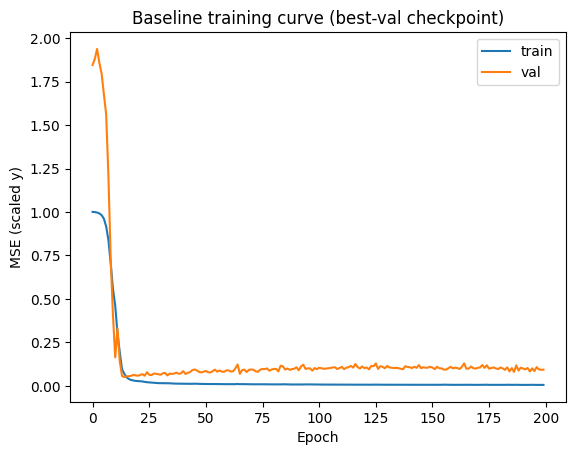

Baseline best val (scaled y): 0.05066531691057929
Baseline val MSE (real $): 173.8054656982422


In [41]:
torch.manual_seed(0)
np.random.seed(0)

b = FCN_5x20(X_train_s.shape[1]).to(device)
opt_b = torch.optim.SGD(b.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)
sched_b = torch.optim.lr_scheduler.CyclicLR(
    opt_b, base_lr=1e-3, max_lr=3e-2, step_size_up=steps_per_epoch*5
)

print("Baseline params:", count_params(b))
print("=== Train Baseline (Momentum+CyclicLR) ===")
hist_b, best_val_b = train_loop_bestval(b, opt_b, epochs, scheduler=sched_b, scheduler_type="cyclic")

plt.figure()
plt.plot(hist_b["train_loss"], label="train")
plt.plot(hist_b["val_loss"], label="val")
plt.xlabel("Epoch")
plt.ylabel("MSE (scaled y)")
plt.title("Baseline training curve (best-val checkpoint)")
plt.legend()
plt.show()

print("Baseline best val (scaled y):", best_val_b)
print("Baseline val MSE (real $):", mse_real_price(b, val_loader))

In [42]:
# Collect candidates (baseline + new model)
all_models = {
    "Baseline_5x20": b,
    **{k: v[0] for k, v in candidate_models.items()}
}


cand_name = "CandA_Slim16_Dropout0.1"
cand_model = all_models[cand_name]  

cand_test_mse = mse_real_price(cand_model, test_loader)
print(f"{cand_name} Test MSE: {cand_test_mse}")

# Also compute linear regression test for reference
print("Linear regression test MSE:", mse_test_lr)

for name in ["Baseline_5x20", "CandA_Slim16_Dropout0.1"]:
    print(name, "Test MSE:", mse_real_price(all_models[name], test_loader))


CandA_Slim16_Dropout0.1 Test MSE: 300.5679626464844
Linear regression test MSE: 7167.110273809454
Baseline_5x20 Test MSE: 1998.711181640625
CandA_Slim16_Dropout0.1 Test MSE: 300.5679626464844


In [45]:
def save_weights(model, path, model_name):
    payload = {
        "model_state_dict": model.state_dict(),
        "feature_stocks": feature_stocks,
        "target_stock": predict_stock,
        "scaler_X_mean": scaler_X.mean_,
        "scaler_X_scale": scaler_X.scale_,
        "scaler_y_mean": scaler_y.mean_,
        "scaler_y_scale": scaler_y.scale_,
        "best_model_name": model_name,
        "baseline_params": baseline_params,
        "best_model_params": count_params(model),
    }
    torch.save(payload, path)
    return path

cand_name = "CandA_Slim16_Dropout0.1"
cand_model = all_models[cand_name]   # 或 candidate_models[cand_name][0]

save_path = save_weights(cand_model, "msft_best_model_weights.pth", cand_name)
save_path

'msft_best_model_weights.pth'

## Result
MSFT Stock Prediction - HW1

Data Split
Train: 2023-01-01 – 2024-06-30  
Validation: 2024-07-01 – 2024-10-31  
Test: 2024-11-01 – 2024-12-31  

### Baseline Network
5 hidden layers × 20 neurons (ReLU)
Parameters: 1921
**Test MSE: 1998.7112**

### Linear Regression
**Test MSE: 7167.11**

### Model Design Challenge
Parameters: 1281
**Test MSE: 300.5680**

Model Weights
Available in this repository.